In [1]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


training epoch 1 of 5
counter =  10000
counter =  20000
training epoch 2 of 5
counter =  30000
counter =  40000
training epoch 3 of 5
counter =  50000
counter =  60000
training epoch 4 of 5
counter =  70000
counter =  80000
training epoch 5 of 5
counter =  90000
counter =  100000
9783 10000 0.9783


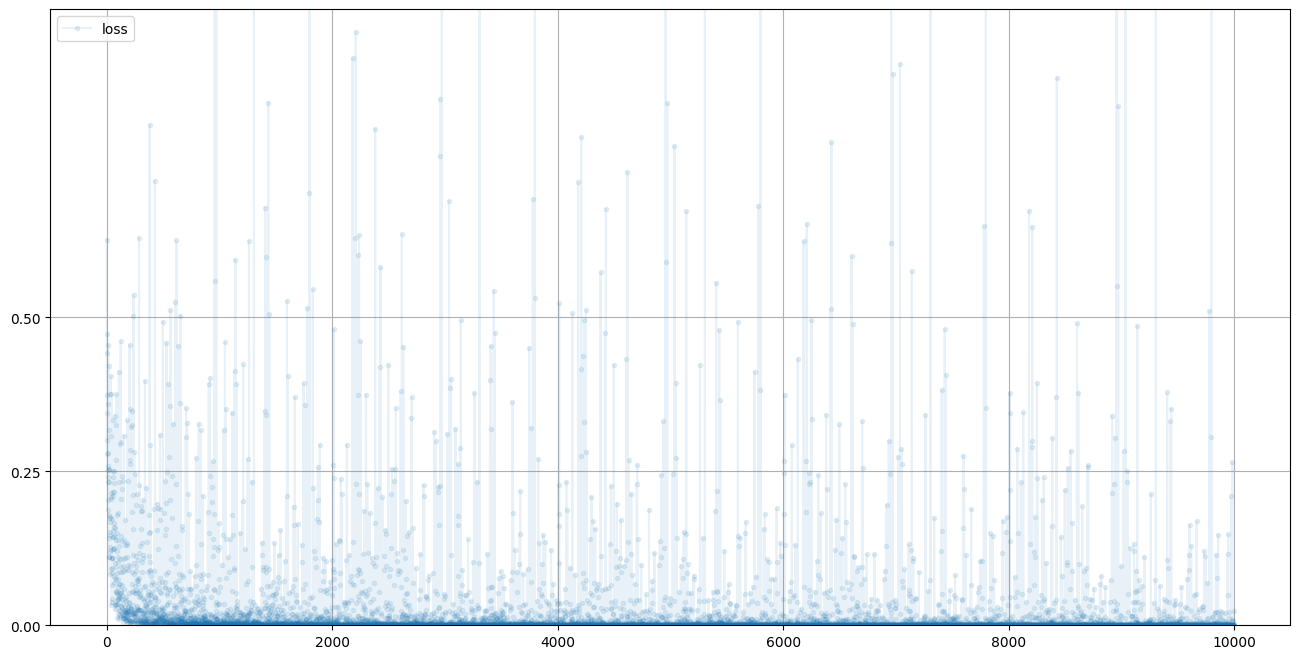

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas
import matplotlib.pyplot as plt

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

mnist_dataset = MnistDataset('sample_data/mnist_train_small.csv')
#mnist_dataset.plot_image(9)

class Classifier(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            # expand 1 to 10 filters
            nn.Conv2d(1, 10, kernel_size=5, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),

            # 10 filters to 10 filters
            nn.Conv2d(10, 10, kernel_size=3, stride=2),
            nn.LeakyReLU(0.02),
            nn.BatchNorm2d(10),

            View(250),
            nn.Linear(250, 10),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters())

        # counter and accumulator for progress
        self.counter = 0
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass

    pass

C = Classifier()

# train network on MNIST data set

epochs = 5

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    for label, image_data_tensor, target_tensor in mnist_dataset:
        C.train(image_data_tensor.view(1, 1, 28, 28), target_tensor)
        pass
    pass

C.plot_progress()

mnist_test_dataset = MnistDataset('sample_data/mnist_test.csv')

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = C.forward(image_data_tensor.view(1,1,28,28)).detach().numpy()
    if (answer.argmax() == label):
        score += 1
        pass
    items += 1

    pass

print(score, items, score/items)



In [ ]:
import h5py
import torch
import torch.nn as nn
import pandas, numpy, random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

'''
with h5py.File('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py', 'r') as file_object:

  for group in file_object:
    print(group)
    pass

with h5py.File('mount/My Drive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['19999.jpg'])
  plt.imshow(image, interpolation='none')
  print(image.shape)
  pass
'''

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

def crop_centre(img, new_width, new_height):
    height, width, _ = img.shape
    startx = width//2 - new_width//2
    starty = height//2 - new_height//2
    return img[  starty:starty + new_height, startx:startx + new_width, :]

class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0

    def plot_image(self, index):
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        # crop to 128x128 square
        img = crop_centre(img, 128, 128)
        plt.imshow(img, interpolation='nearest')
        pass

    pass

celeba_dataset = CelebADataset('mount/MyDrive/Colab Notebooks/celeba_data/celeba_aligned_small.h5py')

#celeba_dataset.plot_image(41)

class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
        # expect input of shape (1,3,128,128)
            nn.Conv2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.Conv2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.Conv2d(256, 3, kernel_size=8, stride=2),
            nn.GELU(),

            View(3*10*10),
            nn.Linear(3*10*10, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)

        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

'''
D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((1,3,128,128)), torch.cuda.FloatTensor([0.0]))
    pass

D.plot_progress()
'''

class Generator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            # input is a 1d array
            nn.Linear(200, 3*11*11),
            nn.GELU(),

            # reshape to 4d
            View((1, 3, 11, 11)),

            nn.ConvTranspose2d(3, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 256, kernel_size=8, stride=2),
            nn.BatchNorm2d(256),
            nn.GELU(),

            nn.ConvTranspose2d(256, 3, kernel_size=8, stride=2, padding=1),
            nn.BatchNorm2d(3),

            # output should be (1,3,128,128)
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # simply run model
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)

        # pass onto Discriminator
        d_output = D.forward(g_output)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 3

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  for image_data_tensor in celeba_dataset:
    # train discriminator on true
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # train discriminator on false
    # use detach() so gradients in G are not calculated
    D.train(G.forward(generate_random_seed(200)).detach(), torch.cuda.FloatTensor([0.0]))

    # train generator
    G.train(D, generate_random_seed(200), torch.cuda.FloatTensor([1.0]))

    pass

  pass

D.plot_progress()
G.plot_progress()

f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(200))
        img = output.detach().permute(0,2,3,1).view(128,128,3).cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


using cuda: Tesla T4
epoch =  1


<ipython-input-2-d6caec54e4c8>:68: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  return torch.cuda.FloatTensor(img).permute(2,0,1).view(1,3,128,128) / 255.0


counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
epoch =  2
counter =  41000
counter =  42000
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =  54000
counter =  55000
counter =  56000
counter =  57000
counter =  58000
counter =  5